<a href="https://colab.research.google.com/github/KeisukeShimokawa/papers-challenge/blob/master/src/gan/CRGAN/notebooks/RandomResizedCrop_Tensor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# free sample
!wget -q https://file-examples.com/wp-content/uploads/2017/10/file_example_JPG_100kB.jpg -O sample.jpg
!ls

sample_data  sample.jpg


In [0]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as tranforms

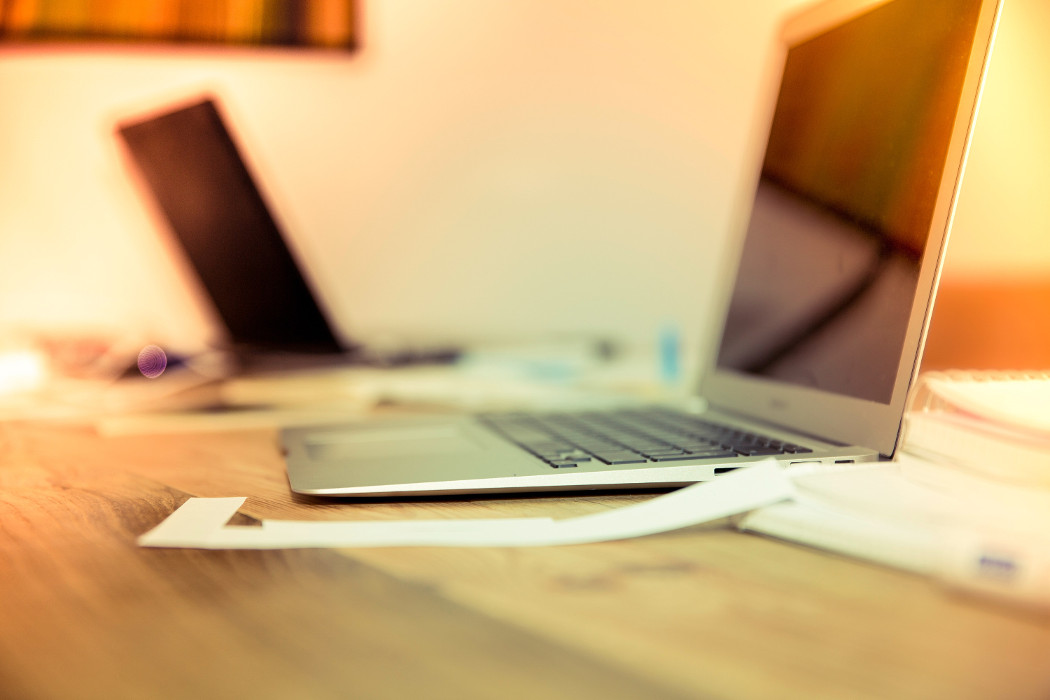

In [3]:
sample_pil = Image.open("sample.jpg")
sample_pil

/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


tensor(0., device='cuda:0') tensor(255., device='cuda:0')
cuda:0
torch.Size([1, 3, 700, 1050])


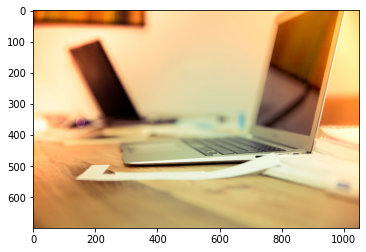

In [4]:
sample = torch.from_numpy(np.asarray(sample_pil)).to("cuda:0", dtype=torch.float)
sample = sample.permute(2, 0, 1)
sample.unsqueeze_(0)

print(sample.min(), sample.max())
print(sample.device)
print(sample.shape)

plt.imshow(sample.cpu().permute(0, 2, 3, 1).numpy().astype(np.uint8)[0])

In [5]:
scale = (0.08, 1.0)
ratio = (3./4., 4./3.)
H, W = sample.shape[2], sample.shape[3]
size = (H, W)

print(size)

area = H * W

print(area)

(700, 1050)
735000


In [0]:
class RandomResizedCropTensor:
    def __init__(self, size, scale, ratio):
        self.size = size
        self.scale = scale
        self.ratio = ratio

    def apply(self, single_tensor):
        r"""Radndomly Resize and Crop torch.Tensor
        :param single_tensor: torch.Tensor [C, H, W]
        """

        H, W = single_tensor.shape[1], single_tensor.shape[2]
        area = H * W

        for _ in range(10):
            target_area = random.uniform(*self.scale) * area
            log_ratio = math.log(self.ratio[0]), math.log(self.ratio[1])
            aspect_ratio = math.exp(random.uniform(*log_ratio))
            z = None
            w = int(round(math.sqrt(target_area * aspect_ratio)))
            h = int(round(math.sqrt(target_area / aspect_ratio)))

            if (0 < w <= W) and (0 < h <= H):
                i = random.randint(0, H - h)
                j = random.randint(0, W - w)
                z = i, j, h, w
                break

        if z is None:
            in_ratio = float(W) / float(H)
            if (in_ratio < min(self.ratio)):
                w = W
                h = int(round(w / min(self.ratio)))
            elif (in_ratio > max(self.ratio)):
                h = H
                w = int(round(h * max(ratio)))
            else:
                w = W
                h = H

            i = (H - h) // 2
            j = (W - w) // 2
            z = i, j, h, w

        print(single_tensor.shape)
        print(i, j, h, w)

        return F.interpolate(single_tensor[:, i:i+h, j:j+w].unsqueeze(0), 
                             size=self.size, 
                             mode="bilinear")[0]


    def __call__(self, image_tensor):
        r"""apply RandomResizedCrop to 4D-Tensor
        :param image_tensor: torch.Tensor [B, C, H, W]
        """
        
        return torch.stack([self.apply(image) for image in image_tensor], dim=0)


In [0]:
test = RandomResizedCropTensor(size, scale, ratio)

In [8]:
test(sample).shape

torch.Size([3, 700, 1050])
92 121 575 673


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2973: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


torch.Size([1, 3, 700, 1050])

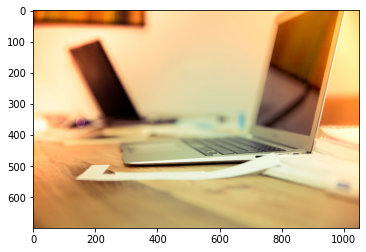

In [9]:
plt.imshow(sample.cpu().permute(0, 2, 3, 1).numpy().astype(np.uint8)[0])

torch.Size([3, 700, 1050])
53 146 631 504


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2973: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


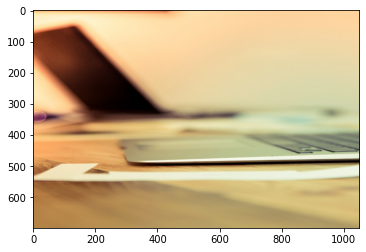

In [10]:
plt.imshow(test(sample).cpu().permute(0, 2, 3, 1).numpy().astype(np.uint8)[0])